In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings("ignore")

### Dataset

In [ ]:
dataset_path = '/content/drive/MyDrive/Research Paper/Health Science/Paper/Acute Lymphoblastic Leukemia/Dataset/'

import os
import glob


train_images = []
mask_images = []
images_dir_name = []

directory = os.listdir(dataset_path)
for dir_ in directory:
  if dir_ == directory[0]:
    for subdir in os.listdir(dataset_path + dir_):
      images_dir_name.append(subdir)
      for img_path in glob.glob(os.path.join(dataset_path, dir_, subdir, "*.jpg")):
        mask_images.append(img_path)
  if dir_ == directory[1]:
    for subdir in os.listdir(dataset_path + dir_):
      images_dir_name.append(subdir)
      for img_path in glob.glob(os.path.join(dataset_path, dir_, subdir, "*.jpg")):
        train_images.append(img_path)

images_dir_name.sort()
train_images.sort()
mask_images.sort()

In [ ]:
from PIL import Image, ImageEnhance
import cv2
import numpy as np

from google.colab.patches import cv2_imshow


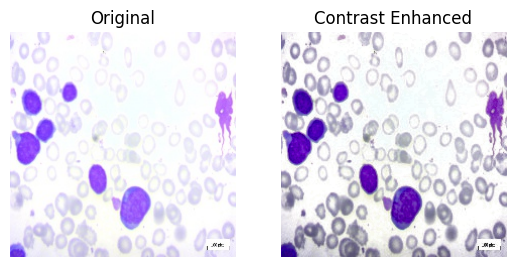

In [ ]:
image = cv2.imread(train_images[0], cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_images[0])

# cv2.COLOR_BGR2HSV (HUE, SATURATION, VALUE)


# converting to LAB color space
lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
l_channel, a, b = cv2.split(lab)

# Applying CLAHE to L-channel

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(5,5))
cl = clahe.apply(l_channel)

# merge the CLAHE enhanced L-channel with the a and b channel
limg = cv2.merge((cl,a,b))

# Converting image from LAB Color model to BGR color spcae
enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(enhanced_img)
plt.title("Contrast Enhanced")
plt.axis("off")
plt.show()

In [ ]:
from matplotlib import colors

rgb_img= cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB)
pixel_colors = rgb_img.reshape((np.shape(rgb_img)[0]*np.shape(rgb_img)[1], 3))

norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

179 255 255


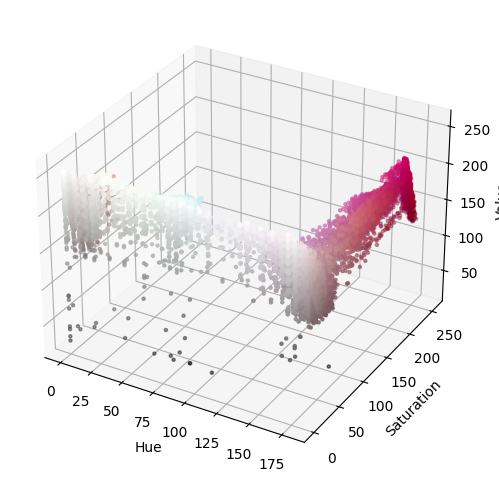

In [ ]:
hue_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hue_img)


h, s, v = cv2.split(hue_img)
print(np.max(h), np.max(s), np.max(v))
fig = plt.figure(figsize=(6, 6))
axis = fig.add_subplot(111, projection='3d')



axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

In [ ]:
light_purple = (165, 70, 70)
dark_purple = (182, 255, 255)

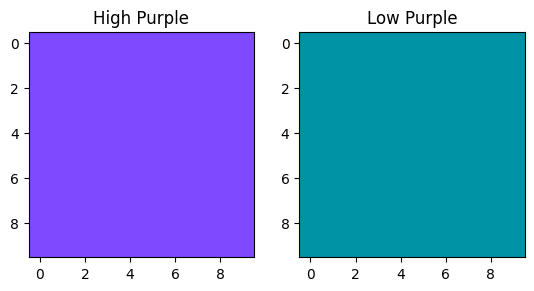

In [ ]:
from matplotlib.colors import rgb_to_hsv

lo_square = np.full((10, 10, 3), light_purple, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_purple, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(rgb_to_hsv(do_square))
plt.title("High Purple")
plt.subplot(1, 2, 2)
plt.imshow(rgb_to_hsv(lo_square))
plt.title("Low Purple")
plt.show()

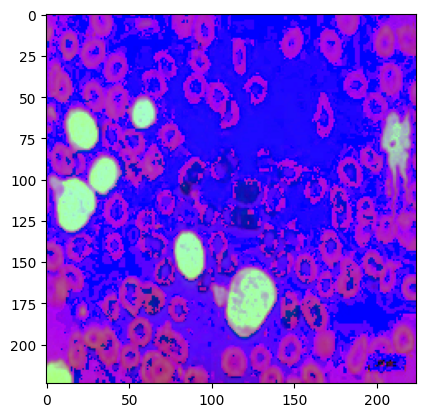

In [ ]:
plt.imshow(hue_img)
plt.show()

In [ ]:
# light_purple = rgb_to_hsv(light_purple)
# dark_purple = rgb_to_hsv(dark_purple)

255


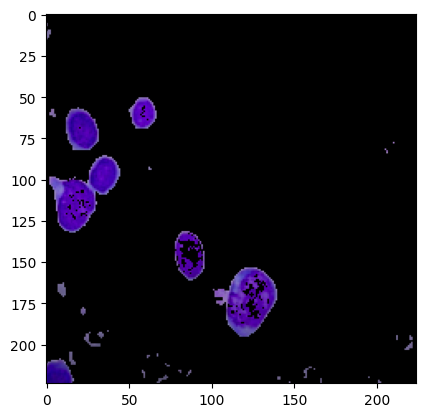

In [ ]:
hsv_mask = cv2.inRange(hue_img, light_purple, dark_purple)

hsv_seg = cv2.bitwise_and(enhanced_img, enhanced_img, mask=hsv_mask)
print(np.max(hsv_mask))
plt.imshow(hsv_seg , cmap='gray')
plt.show()

### Color Based Segmentation

### Binary Threshold Operation

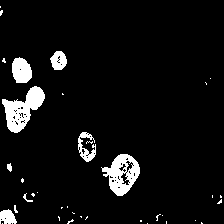

In [ ]:
gray_img = cv2.cvtColor(hsv_seg, cv2.COLOR_BGR2GRAY)
thresh, binary_img = cv2.threshold(gray_img, 127, 255, cv2.THRESH_OTSU)
cv2_imshow(binary_img)

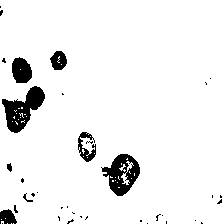

In [ ]:
inv_binary_img = cv2.bitwise_not(binary_img)
cv2_imshow(inv_binary_img)

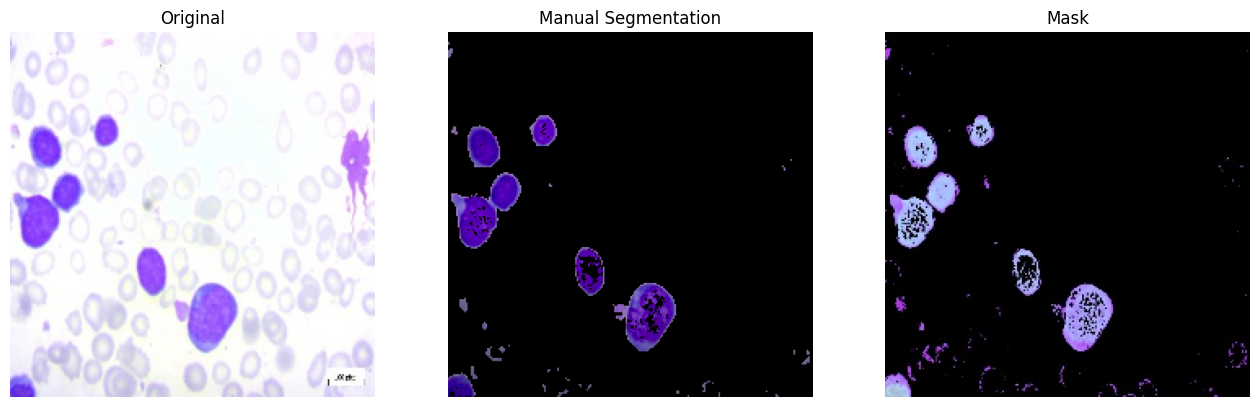

In [ ]:
merge_img = cv2.bitwise_and(enhanced_img, enhanced_img,  mask=binary_img)


plt.figure(figsize=(16, 10))

plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(merge_img)
plt.title("Manual Segmentation")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title("Mask")
plt.axis("off")

plt.show()

In [ ]:
import tensorflow as tf

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
mask = mask.astype(np.float32)
merge_img = merge_img.astype(np.float32)
DSC = dice_loss(mask, merge_img)
DSC

<tf.Tensor: shape=(), dtype=float32, numpy=-114.548164>

### Contour Operation

In [ ]:
import imutils

In [ ]:
cnts = cv2.findContours(inv_binary_img.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key=cv2.contourArea, reverse=True)[0:10]

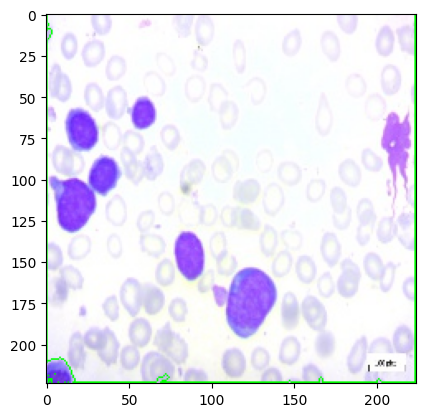

In [ ]:
output = image.copy()
cv2.drawContours(output, c, -1, (0, 255, 0), 1)
plt.imshow(output)
plt.show()

### Patching

In [ ]:
! pip install patchify

In [ ]:
from patchify import patchify

patches = patchify(merge_img, (64, 64, 3), step=64)
patches.shape

(3, 3, 1, 64, 64, 3)

In [ ]:
patch = patches[2, 0, 0, :, :, :]

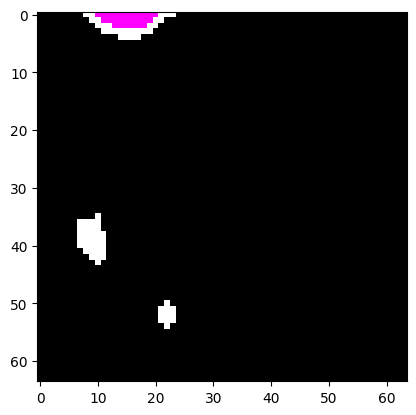

In [ ]:
patch_gray = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
plt.imshow(patch, cmap='gray')
plt.show()

In [ ]:
patch_gray.shape

(64, 64)

In [ ]:
patch_gray.mean()

2.2974572

In [ ]:
new_arr = patch_gray.flatten()
for i in range(len(new_arr)):
  if new_arr[i] >= new_arr.mean():
    new_arr[i] = 1
  else:
    new_arr[i] = 0
gray_img_reshaped = new_arr.reshape(patch.shape[0], patch.shape[1])

In [ ]:
np.median(gray_img_reshaped)

0.0

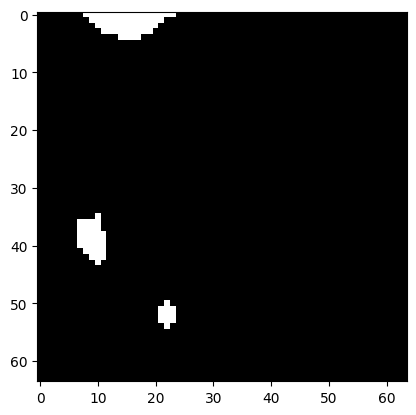

In [ ]:
plt.imshow(gray_img_reshaped, cmap='gray')

### Region of Segmentation

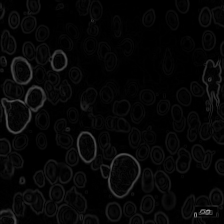

In [ ]:
img_float = image.astype(np.float32)
from skimage.filters import sobel
imm = img_float[:, :, 0]
elevation_map = sobel(imm)
cv2_imshow(elevation_map)

In [ ]:
imm.shape

(224, 224)

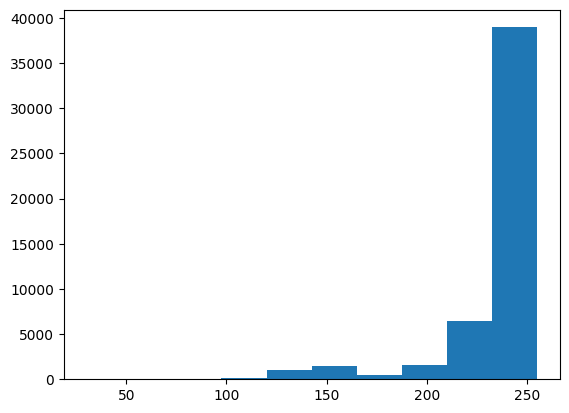

In [ ]:
plt.hist(imm.flatten())
plt.show()

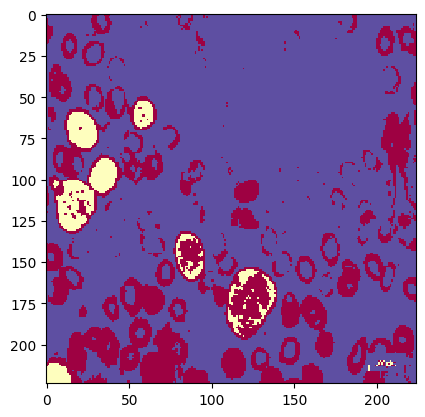

In [ ]:
markers = np.zeros_like(imm)
markers[imm < 150] = 1
markers[imm > 235] = 2

plt.imshow(markers, cmap='Spectral', interpolation='nearest')
plt.show()

In [ ]:
elevation_map.shape, markers.shape

((224, 224), (224, 224))

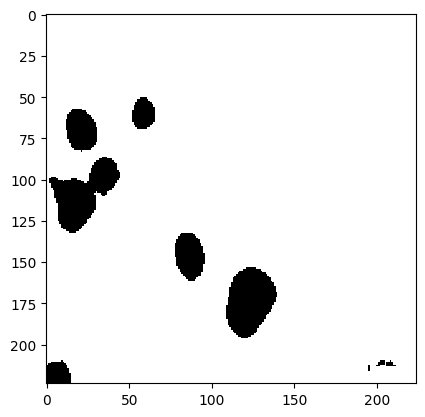

In [ ]:
import skimage

segmentation = skimage.segmentation.watershed(elevation_map, markers)

plt.imshow(segmentation, cmap='gray', interpolation='nearest')
plt.show()

In [ ]:
image.shape, segmentation.shape

((224, 224, 3), (224, 224))

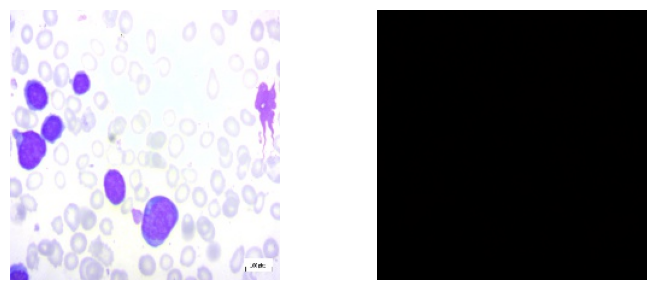

In [ ]:
from skimage.color import label2rgb
from scipy import ndimage as ndi

# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
segmentation_coins = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation_coins)
image_label_overlay = label2rgb(labeled_coins, image=image, bg_label=0)

fig, axes = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
axes[0].imshow(image.astype(np.uint8), cmap=plt.cm.gray)
axes[0].contour(segmentation_coins, [2.0], linewidths=1.2, colors='y')
axes[1].imshow(image_label_overlay.astype(np.uint8))

for a in axes:
    a.axis('off')

plt.tight_layout()

plt.show()

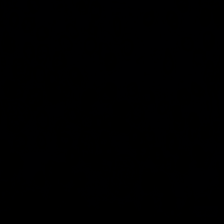

In [ ]:
cv2_imshow(image_label_overlay)